In [1]:
%load_ext autoreload
%autoreload 1
%aimport genesis.streaming

# Streaming Alerts (with Genesis)

Made possible by:
* Heising-Simons Foundation
* Washington Research Foundation
* Charles and Lisa Simonyi Fund for Arts and Sciences


## What is Alert Streaming and When to Use It



Classis survey science is not performed in real time: the analysis usually usually lags the data collection and processing. Typically, a researcher waits for (days to weeks) for a reasonably sized batch of new data to be accumulated and then performs the analysis (and frequently manually).

This does not work well for use cases where the object of interest may change on short timescales and needs to be followed up rapidly. An example may be a short-timescale transient, or a potentially hazardous asteroid undergoing in an Earth flyby. For this use case, the researcher would prefer to be analyzing the data as they come in, with minimal latency between data collection and the understanding of whether a particular datum is interesting.

This is solved by alert streaming: near real-time transmission of alerts to (and measurements of) objects whose properties have changed. The key differences between the "classic" and streaming-driven approach:
1. Response time on order of seconds
1. Fully automated, machine-driven, analysis

## Streaming Challenges

* Minimal latency
* Robustness to transmission issues
* Ease of use

## Apache Kafka

...

We've set up:
1. A small static topic with only 100 alerts
2. A topic with continuously injected alerts at a reasonably small rate
3. A topic with continuously injected alerts at LSST scale

## Genesis Broker Access Library

Kafka comes with performant Python libraries roughly following the API and structure of their native (Java) client libraries.

Included with this demo is an early version of `genesis.streaming`, a client library for robust and scalable access to alert streams. Genesis largely abstracts away both the underlying transport protocol and alert serialization: to the user, alerts are simple Python `dict`s, delivered through familiar `generator`s.

In [2]:
import genesis.streaming as gs

## Simple Streaming

If you execute the cell below, it will hang forever... (click the stop ◾️button in your Jupyter to interrupt it).

In [ ]:
with gs.open("kafka://broker0.do.alerts.wtf/test8") as stream:
    for idx, alert in stream:
        print("Candidate ID:", alert.candid)

What happened: Genesis (actually, Kafka) remembers what was the last alert you received from any topic (the ***offset*** of the last received alert), and will only send you new alerts. This is desired behavior -- if you weren't connected immediately when the night started (or got temporarily disconnected), you may want to catch up.

But what if this is your first time you connected to the stream? If so, Genesis will default to waiting for new packets, and not sending you anything it may already have. This is a safe default: e.g., if the first time you connect to the LSST stream is one year into operations, you don't want to be sent a year's worth of alerts!

In our case, since I'm not injecting any new alerts, it will wait indefinitely...

Let's change this default, and have it send us everything it has. We'll also turn on a nice progress bar, and we will tell it to stop if it doesn't receive an alert in a 10 second interval.

In [8]:
with gs.open("kafka://broker0.do.alerts.wtf/test8", start_at="earliest") as stream:
    for idx, alert in stream(timeout=10, progress=True):
        print("[%d] Candidate ID: %s" % (idx, alert.candid))

Generated fake groupid mjuric-5W0ZL9GSY5AUG9F5F1F7


[0] Candidate ID: 619125124815010009
[1] Candidate ID: 619125123315010006
[2] Candidate ID: 619125123315010007
[3] Candidate ID: 619125122115010004
[4] Candidate ID: 619124523115015003
[5] Candidate ID: 619125123315010003
[6] Candidate ID: 619124520915010000
[7] Candidate ID: 619125120915010000
[8] Candidate ID: 619124523915010008
[9] Candidate ID: 619125122115010005
[10] Candidate ID: 619124525715010009
[11] Candidate ID: 619125120615015002
[12] Candidate ID: 619125122015010005
[13] Candidate ID: 619125123515015014
[14] Candidate ID: 619125124915010010
[15] Candidate ID: 619124522715010001
[16] Candidate ID: 619124525815015000
[17] Candidate ID: 619124525515010000
[18] Candidate ID: 619125121915015005
[19] Candidate ID: 619124523115010001
[20] Candidate ID: 619124523815010002
[21] Candidate ID: 619125122315010007
[22] Candidate ID: 619125123315015000
[23] Candidate ID: 619125124915010008
[24] Candidate ID: 619125123215015000
[25] Candidate ID: 619125123315010001
[26] Candidate ID: 619

You may notice a slight pause before the streaming starts: this is Kafka establishing connections to the broker cluster. Once the connections are established, the alerts start streaming quickly.

In [17]:
with gs.open("kafka://broker0.do.alerts.wtf/test8", start_at="earliest") as stream:
    alerts = [ alert.candid for _, alert in stream(timeout=10, progress=True) ]

alerts.sort()

print(f"Read {len(alerts)} alerts.")
print("First few candidate IDs:", alerts[:3])

Generated fake groupid mjuric-I0I3QY4D6D2ME4U69UFC



Read 100 alerts.
First few candidate IDs: [619124520615010001, 619124520615015004, 619124520915010000]


### Remembering "offsets"

Kafka can remember the `offset` of the last transmitted alert; next time you connect, it will start streaming from that offset.

For this to work, we need to connect to a stream with a "consumer ID" -- a name uniquely identifying you. Kafka will associate the offset to the consumer ID; the next time the same consumer ID connects, it will continue streaming the offset associated to it.

Let's generate a random consumer ID for your demo session, and add it to the stream URL:

In [13]:
import random, string

id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))
broker_url = "kafka://{}@broker0.do.alerts.wtf/test8".format(id)

print("Consumer ID:", id)
print("Broker URL: ", broker_url)

Consumer ID: BF78D3GC
Broker URL:  kafka://BF78D3GC@broker0.do.alerts.wtf/test8


Let's read in a few alerts:

In [23]:
with gs.open(broker_url, start_at="earliest") as stream:
    alerts1 = [ alert.candid for _, alert in stream(limit=25, progress=True) ]
    
    # ... now do some work with the alert ...
    
    # stream.commit()

alerts1.sort()

print(f"Read {len(alerts1)} alerts.")
print("First few candidate IDs:", alerts1[:3])


Read 25 alerts.
First few candidate IDs: [619124520915010000, 619124520915010002, 619124522015010000]


COMMITTING


Let's read in the rest:

In [24]:
with gs.open(broker_url, start_at="earliest") as stream:
    alerts2 = [ alert.candid for _, alert in stream(timeout=10, progress=True) ]

    # ... now do some work with the alert ...
    
    # stream.commit()

alerts2.sort()

print(f"Read {len(alerts2)} alerts.")
print("First few candidate IDs:", alerts2[:3])


Read 75 alerts.
First few candidate IDs: [619124520615010001, 619124520615015004, 619124521415015003]


COMMITTING


Why didn't it continue from wher we left off?

Because the broker needs to be _explicitly_ told to commit the offset. It doesn't do so automatically to prevent data loss. 

To illustrate: if we committed the offset as soon as the alert is returned to you, and the code in _"... now do some work with the alert ..."_ section above crashes before acting on the alerts, the next time you connect to the broker these alerts would be skipped.

This is why you must explicitly call `stream.commit()` once you're certain the received alerts were successfully processed.

Now go back up, uncommend the `stream.commit()` lines, and re-execute these two cells.

Finally, let's verify nothing was lost:

In [25]:
set(alerts) == set(alerts1 + alerts2)

True

Warning: 
* Kafka does not guarantee the order in which you'll receive the alerts -- it guarantees delivery, but some may be out of order.
* Kafka (typically) guarantees "at least once" delivery -- that is, you may receive some alerts more than once (if there's a crash, a network interruption, or any similar exceptional situation). Your code should guard agaist this. Exactly-once semantics difficult, but possible (and coming in the future).

![Distributed computing problems](https://cdn.confluent.io/wp-content/uploads/image2.png)

## Filtering the stream

Now let's filter the stream for objects of interest. Say we're only interested in asteroids, and wish to ignore the rest.

We'll write a filter function which checks whether the alert candidate has the "Nearby Solar System object Name" field set to something other than "null":

In [27]:
def filter_asteroids(alert):
    if alert.candidate.ssnamenr != 'null':
        return alert
    else:
        return None

In [32]:
with gs.open("kafka://broker0.do.alerts.wtf/test6", start_at="earliest") as stream:
    for idx, alert in stream(limit=10, timeout=10, progress=True, filter=filter_asteroids):
        print(f"[{idx}] Candidate ID: {alert.candid} {alert.candidate.ssnamenr}")

Generated fake groupid mjuric-EUCIK9OFOHLIFQWTY1KS


[8] Candidate ID: 619483561715015106 27083
[23] Candidate ID: 619393686115015014 66021
[87] Candidate ID: 619252675415015008 163650
[102] Candidate ID: 619363585815015021 336999
[109] Candidate ID: 619362671715015011 39954
[153] Candidate ID: 619365495615015017 19728
[159] Candidate ID: 619484475315015004 58107
[166] Candidate ID: 619483561115015016 8803
[175] Candidate ID: 619331290015015030 454337
[178] Candidate ID: 619396552815015013 94550



By looking at the [fields available in the alert packet](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html), you can construct arbitrarily complex filters.

Here's one that checks whether an object may be a transient:

In [42]:
import pandas as pd
import numpy as np
import astropy.units as u

def is_transient(alert):

    # if only a single discovery, bail out -- we wait for at least two
    # before triggering
    if alert.prv_candidates is None:
        return
    
    dflc = pd.DataFrame( [ alert.candidate ] + alert.prv_candidates)
    candidate = dflc.loc[0]

    # positive subtraction?
    is_positive_sub = candidate['isdiffpos'] == 't'
    
    # no nearby source
    if (candidate['distpsnr1'] is None) or (candidate['distpsnr1'] > 1.5):
        no_pointsource_counterpart = True
    else:
        # nearby source, but it's a galaxy?
        if candidate['sgscore1'] < 0.5:
            no_pointsource_counterpart = True
        else:
            no_pointsource_counterpart = False
            
    where_detected = (dflc['isdiffpos'] == 't') # nondetections will be None
    if np.sum(where_detected) >= 2:
        detection_times = dflc.loc[where_detected,'jd'].values
        dt = np.diff(detection_times)
        not_moving = np.max(dt) >= (30*u.minute).to(u.day).value
    else:
        not_moving = False
    
    no_ssobject = (candidate['ssdistnr'] is None) or (candidate['ssdistnr'] < 0) or (candidate['ssdistnr'] > 5)
    
    if is_positive_sub and no_pointsource_counterpart and not_moving and no_ssobject:
        return alert

    return None

In [50]:
with gs.open("kafka://broker0.do.alerts.wtf/test6", start_at="earliest") as stream:
    for idx, alert in stream(limit=10, timeout=10, progress=True, filter=is_transient):
        print(f"[{idx}] Candidate ID: {alert.candid}")

Generated fake groupid mjuric-TR4WKTCQKC55M4MYYJ0Y


[292] Candidate ID: 619224543515015147
[373] Candidate ID: 619373923515015071
[374] Candidate ID: 619277083515015102
[443] Candidate ID: 619513780215015051
[476] Candidate ID: 619283441015015040
[518] Candidate ID: 619170694515015018
[708] Candidate ID: 619323493515015073
[755] Candidate ID: 619170690715015097
[802] Candidate ID: 619303311415015009
[817] Candidate ID: 619259251615015155



The filter in the above example was (intentionally) written to be slow. At this processing rate, it may not be able to keep up with the full LSST alert stream.

Fortunately, Genesis knows how to parallelize execution over multiple cores, using Python's `multiprocessing.Pool`:

In [49]:
from multiprocessing import Pool

with Pool(4) as workers:
    with gs.open("kafka://broker0.do.alerts.wtf/test6", start_at="earliest") as stream:
        for idx, alert in stream(pool=workers, limit=10, timeout=10, progress=True, filter=is_transient):
            print(f"[{idx}] Candidate ID: {alert.candid}")

Generated fake groupid mjuric-KE5AF1G2DBU62RWC92AN


[266] Candidate ID: 619373923515015071
[267] Candidate ID: 619277083515015102
[336] Candidate ID: 619513780215015051
[398] Candidate ID: 619224543515015147
[598] Candidate ID: 619283441015015040
[640] Candidate ID: 619170694515015018
[697] Candidate ID: 619303311415015009
[712] Candidate ID: 619259251615015155
[810] Candidate ID: 619323493515015073
[857] Candidate ID: 619170690715015097



## Robustness

Kafka is a distributed system robust to component failures.

The cluster of kafka brokers in our demo setup has a "replication factor" of 2 -- that is, each alert is mirrored on at least two brokers. Therefore, one broker may fail without a data loss; the clients will transparently switch to receive data from the other replica. Let's demonstrate this!

When I give a signal, please start the cell below. It will start downloading alerts from a topic with 10,000 alerts. As it's running, I will shut down one of the brokers in the cluster; your client should still download the full 10,000 alerts.

In [52]:
with gs.open("kafka://broker0.do.alerts.wtf/test8", start_at="earliest") as stream:
    for idx, alert in stream(timeout=10, progress=True):
        # we'll do nothing -- just show the progress bar.
        pass;

Generated fake groupid mjuric-Q2ENHTZUEBY6P5GIX2JU


## Scalability

And now for the main event: let's see if we can stream and filter alerts at the full LSST rate!

I have set up a script that injects 10,000 LSST-sized ZTF alerts every 40 seconds (average LSST rate).

When I give the signal, please execute the cell below to start consuming from this stream. We will observe how many simultaneous users we can have before the system fails to keep up!

In [ ]:
with gs.open("kafka://broker0.do.alerts.wtf/test9", start_at="earliest") as stream:
    for idx, alert in stream(timeout=60, progress=True):
        # we'll do nothing -- just show the progress bar.
        pass;

#######################

## Scrap code below, remove before demo

In [47]:
import genesis.streaming as gs

source = gs.jupyter_stream("kafka://broker0.do.alerts.wtf/test8", start_at='earliest')

alerts = list(source.consume(maxread=10))

#for nread, (idx, rec) in enumerate(source.consume(maxread=10)):
#    # Act on received information
#    cd = rec.candidate
#    print(f"[{datetime.now()}] {nread}/{idx}:", cd.jd, cd.ssdistnr, cd.ssnamenr)

LEAVING c
CLOSED c


LEAVING!


LEAVING c
CLOSED c


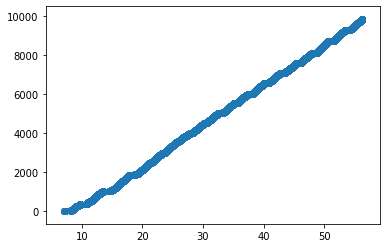

In [10]:
from datetime import datetime
import matplotlib.pyplot as plt
import time
from IPython import display

def my_filter(msg):
    return msg
    return None if msg.candidate.ssnamenr == 'null' else msg

from tqdm import tqdm_notebook as tqdm
tt = tqdm(desc='Alerts processed', unit=' alerts', mininterval=0.5, smoothing=1, miniters=0)

t, n = [], []
t0 = tplot = time.time()
for nread, (idx, rec) in enumerate(
    gs.stream("kafka://broker0.do.alerts.wtf/test6", my_filter, ncores=1, start_at='earliest')
):
    t += [ time.time() - t0 ]
    n += [ nread ]
    tt.update()

    if time.time() - tplot >= 2:
        plt.scatter(x=t, y=n)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        tplot = time.time()

    # Act on received information
#    cd = rec.candidate
#    print(f"[{datetime.now()}] {nread}/{idx}:", cd.jd, cd.ssdistnr, cd.ssnamenr)
    if nread == 10000:
        print("LEAVING!")
        break

LEAVING c
CLOSED c


KeyboardInterrupt: 

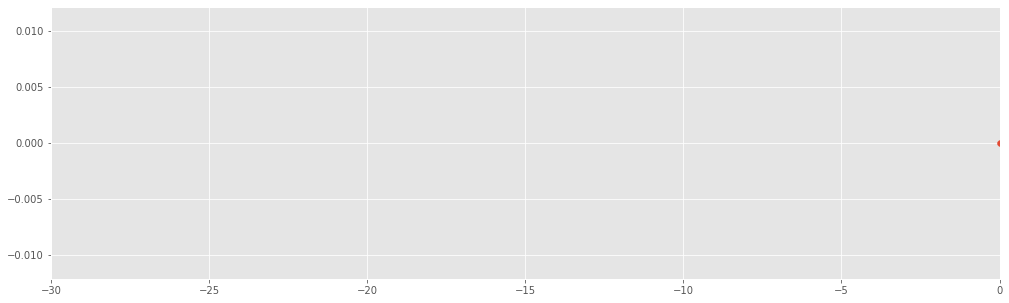

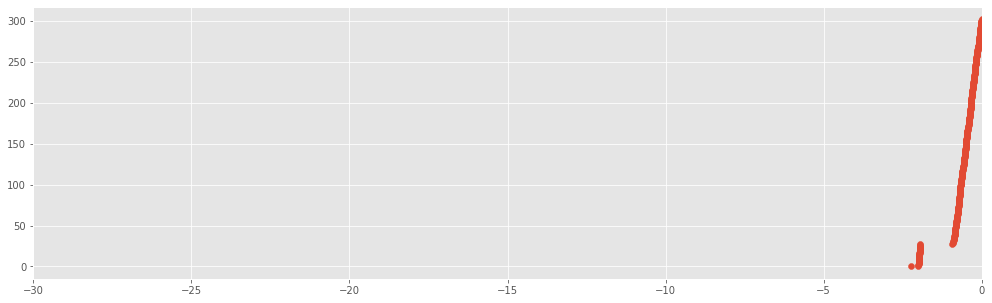

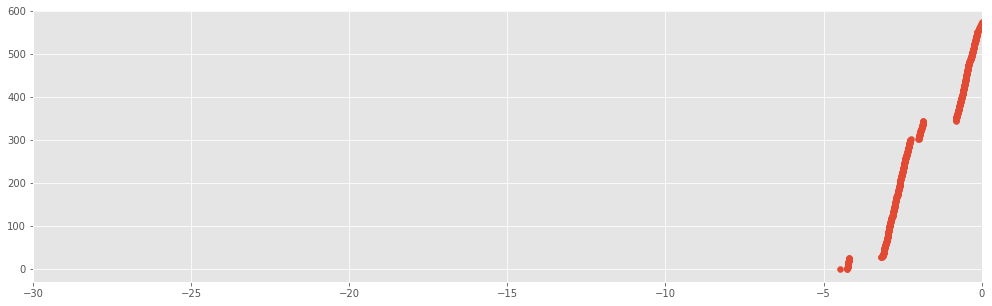

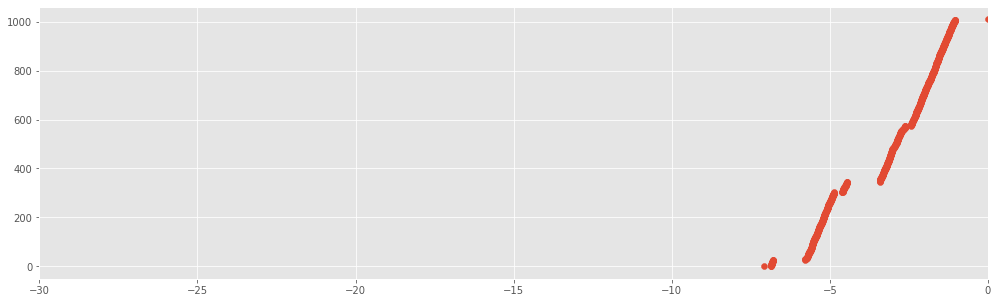

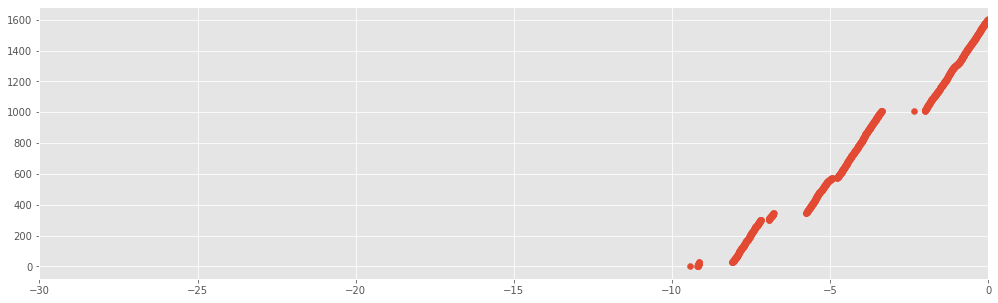

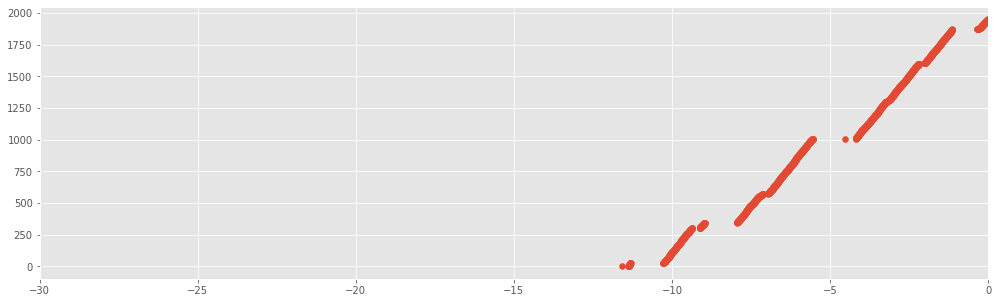

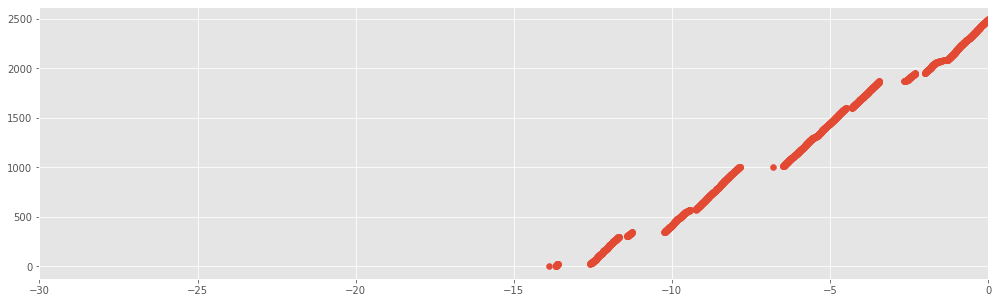

In [27]:
from datetime import datetime
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython import display

def my_filter(msg):
    return msg
    return None if msg.candidate.ssnamenr == 'null' else msg

plt.style.use('ggplot')

t, n = [], []
t0 = tplot = time.time()
for nread, (idx, rec) in enumerate(
    gs.stream("kafka://broker0.do.alerts.wtf/test6", my_filter, ncores=1, start_at='earliest')
):
    t += [ time.time() ]
    n += [ nread ]

    now = time.time()
    if now - tplot >= 2:
        tt = np.array(t)
        nn = np.array(n)
        tt -= now
        mask = tt > -30
        plt.figure(figsize=(17, 5))
        plt.scatter(x=tt, y=nn)
        plt.xlim((-30, 0))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        tplot = time.time()

    # Act on received information
#    cd = rec.candidate
#    print(f"[{datetime.now()}] {nread}/{idx}:", cd.jd, cd.ssdistnr, cd.ssnamenr)
    if nread == 10000:
        print("LEAVING!")
        break

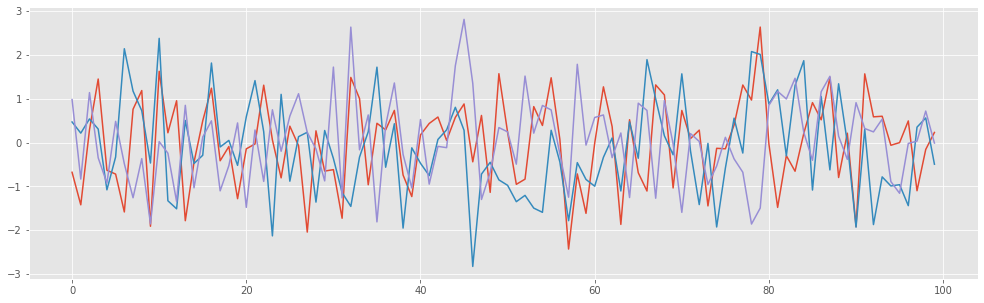

In [16]:
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(17, 5))

import time
import pylab as pl
from IPython import display
try:
    for i in range(10):
        pl.plot(pl.randn(100))
        display.display(pl.gcf())
        display.clear_output(wait=True)
        time.sleep(1.0)
except KeyboardInterrupt:
    pass